<font size="85">New Brunswick 27° Gable Roof Building: Wind Tunnel Test</font> <br>
***
Feb 25, 2023

# Project description

The study building is a $27^\circ$ gable roof building with ridge height 9.8 m, width 14 m, and length 41 m. It is situated in a suburban surrounding all around except the North end. The North is exposed to an open terrain from the airport except for a couple of houses immediately next to it. 

| Parameter | Value |
| --- | --- |
| Geometric scale | 1:100 |
| Velocity scale | TBD |
| Sampling period | 180s |
| Sampling frequency | 500Hz |
| Reference wind tunnel speed | 60fps |
| Number of exposures to be tested | Two exposures |
| Profile measurement | Not required |
| Tunnel setup | The tunnel configurations for the two exposures are given in Table 1 |
| Pressure taps | 440 taps (see Figure 3 for the layout) |
| Number of scanners required | 30 |
| Test angles, $\theta$ | 0° to 350° at 10°; 45°; 135°; 225°; and 315°. (40 directions) |
| Number of runs | 8 (2 field conditions of Case 1, 6 for the other cases) |
| Other instrumentation | None |
| Dummy models | The dummy models will be built from the dense foam typically used by BLWTL to model surrounding buildings. |
| Turntable setup | Several neighboring buildings and trees close to the study building will be crudely modeled for Case 1. |


**Case matrix**
| Case | Name | Surround | Exp-2 | Exp-4 |
| --- | --- | --- | --- | --- |
| 1 | fld | X | X | X |
| 2 | iso |  | X |  |
| 3 | xd |  | X |  |
| 4 | xdd |  | X |  |
| 5 | dxd |  | X |  |
| 6 | xddd |  | X |  |
| 7 | dxdd |  | X |  |



## Basic definitions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import wind
import windBLWT as wt
import windCAD

import winsound

### Files and directories

In [3]:
# Directories
rawHFPIdir = r"E:/nrcNB_windTunnelData/rawHFPI/"
workDir = r"D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/"
rawVelDir = workDir + r"Data/windTunnel/profiles/"
outputDir = workDir + r"Data/windTunnel/"
figDir = outputDir + r"__plots/"

# Files
tapFile = workDir + r"Drawings/nrcNBwtTapDefinition.csv"


### General parameters

In [4]:
saveFigs = True
exps = ['E2','E3']
cases = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
exp = exps[0]
caseID = cases[1]

caseToRun = 'nrcNB'+caseID+exp
casedir = rawHFPIdir+caseToRun+r"/"

profileDir = rawVelDir #+'tng'+exp+'/'

In [5]:
if os.path.exists(casedir):
    print(casedir)
else:
    raise FileNotFoundError(casedir)

E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/


### Scaling
The geometric length scale is decided based on the optimal fitting the model in the wind tunnel.
$$ \lambda_L=1:100 $$

The velocity scale is calculated by assuming the design wind speed according to NBCC 2020. The values for Moncton, NB (the nearest available location to Dieppe, NB), are:
$$ q_{1/50}=0.5 kPa $$
$$ U_{10}=\sqrt{\frac{2q}{\rho}}=27.8 m/s $$

Assuming an approximate roof height wind speed at the model scale to be $U_H^{WT}=10m/s$ (will be updated after the test) and considering the roof height ($H=8m/s$) close enough to $10m$:
$$ \lambda_V= \frac{U_H^{WT}}{U_{10}}=1:2.78 $$

Thus, the time scale is:
$$ \lambda_T = \frac{\lambda_L}{\lambda_V} = 1:36 $$

$\implies$ the model scale duration equivalent to the full-scale $1hr$ is $100s$.

## Building Geometry

### Basic geometry

| Dimension | Unit |
| --- | --- |
| Length | $m$ |
| Time | $s$ |
| Velocity | $m/s$ |
| Density | $kg/m^3$ |

In [6]:
H = 80*wind.mm2m  # average roof height
Hr = 97.5*wind.mm2m  # ridge height
He = 62.5*wind.mm2m  # eaves height
Havg = np.mean([Hr, He])
B = 410*wind.mm2m
D = 138.7*wind.mm2m
roofSlope = 26.1  # roof slope

lScl=1/100.0
vScl=1/2.78
tScl=lScl

badTaps = []

### Basics of faces

In [7]:

tapData = pd.read_csv(tapFile, na_filter=False)

faceID = [1,2,3,4,5,6]
name = ['West_roof','East_roof','East_wall','North_wall','West_wall','South_wall']
note = ['','','','','','']
origin = [[0, -71.6, 62.5], [0, 71.6, 62.5], [0, 69.35, 0], [-205, 0, 0], [0, -69.35, 0], [205, 0, 0], ]

basisVectors = [
            [[1, 0, 0], [0, 0.898027575760616, 0.439939169855915], [0, -0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, -0.898027575760616, 0.439939169855915], [0, 0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, 0, 1], [0, 1, 0]], 
            [[0, -1, 0], [0, 0, 1], [-1, 0, 0]], 
            [[1, 0, 0], [0, 0, 1], [0, -1, 0]], 
            [[0, 1, 0], [0, 0, 1], [1, 0, 0]], 
            ]

# origin_plt = [[0, 79.6967], [0, -79.6967], [0, -223.5182], [-357.0189, 0], [0, -223.5182], [357.0189, 0], ]
origin_plt = [[0, -79.6967], [0, -79.6967], [0, -150], [0, -320], [0, -150], [0, -320], ]

basisVectors_plt = [
            [[1, 0], [0, 1]],       # Face 1 (West_roof)
            [[-1, 0], [0, -1]],     # Face 2 (East_roof)
            [[-1, 0], [0, -1]],     # Face 3 (East_wall)
            [[0, 1], [-1, 0]],      # Face 4 (North_wall)
            [[1, 0], [0, 1]],       # Face 5 (West_wall)
            [[0, -1], [1, 0]],      # Face 6 (South_wall)
            ]

vertices_basic = [
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 1
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 2
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 3
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 4
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 5
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 6
            ]

vertices_face_1a = [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [72.4, 0], [51.85, 24.6713], 
                    [31.3, 0], [-55.6, 0], [-83.05, 24.6713], [-110.5, 0], [-207.25, 0], ]
vertices_face_5a = [[-205, 0], [-205, 60.76], [-108.25, 60.76], [-108.25, 0], [-205, 0], ]
vertices_face_5b = [[-57.85, 0], [-57.85, 60.76], [33.55, 60.76], [33.55, 0], [-57.85, 0], ]
vertices_face_5c = [[70.15, 0], [70.15, 60.76], [205, 60.76], [205, 0], [70.15, 0], ]

            

### Zone dictionary


#### Case 2

In [8]:
zoneDict_basic = [
        {   # Face 1
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 0, ], [193.38, 13.87, ], [207.25, 13.87, ], [207.25, 0, ], [193.38, 0, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone c', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
            3:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone sp', np.array([[179.51, 65.8267, ], [179.51, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [179.51, 65.8267, ], ])],
            5:['NBCC 2020', 'Zone sp', np.array([[193.38, 13.87, ], [193.38, 65.8267, ], [207.25, 65.8267, ], [207.25, 13.87, ], [193.38, 13.87, ], ])],
            6:['NBCC 2020', 'Zone sp', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [-193.38, 79.6967, ], [-193.38, 65.8267, ], [-179.51, 65.8267, ], ])],
            7:['NBCC 2020', 'Zone sp', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
            8:['NBCC 2020', 'Zone s', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [179.51, 79.6967, ], [179.51, 65.8267, ], [-179.51, 65.8267, ], ])],
            9:['NBCC 2020', 'Zone s', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [193.38, 13.87, ], [193.38, 0, ], [-193.38, 0, ], ])],
           10:['NBCC 2020', 'Zone r', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 13.87, ], [-193.38, 13.87, ], ])],
        #    11:['ASCE 7-22', 'Zone 3', np.array([[-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], ])],
        #    12:['ASCE 7-22', 'Zone 3', np.array([[207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], ])],
        #    13:['ASCE 7-22', 'Zone 2', np.array([[-207.25, 65.8267, ], [-207.25, 0, ], [-193.38, 0, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], ])],
        #    14:['ASCE 7-22', 'Zone 2', np.array([[207.25, 65.8267, ], [207.25, 0, ], [193.38, 0, ], [193.38, 65.8267, ], [207.25, 65.8267, ], ])],
        #    15:['ASCE 7-22', 'Zone 2', np.array([[-193.38, 79.6967, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 79.6967, ], [-193.38, 79.6967, ], ])],
        #    16:['ASCE 7-22', 'Zone 1', np.array([[-193.38, 65.8267, ], [-193.38, 0, ], [193.38, 0, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
        },
        {   # Face 2
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 0, ], [193.38, 13.87, ], [207.25, 13.87, ], [207.25, 0, ], [193.38, 0, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone c', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
            3:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone sp', np.array([[179.51, 65.8267, ], [179.51, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [179.51, 65.8267, ], ])],
            5:['NBCC 2020', 'Zone sp', np.array([[193.38, 13.87, ], [193.38, 65.8267, ], [207.25, 65.8267, ], [207.25, 13.87, ], [193.38, 13.87, ], ])],
            6:['NBCC 2020', 'Zone sp', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [-193.38, 79.6967, ], [-193.38, 65.8267, ], [-179.51, 65.8267, ], ])],
            7:['NBCC 2020', 'Zone sp', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
            8:['NBCC 2020', 'Zone s', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [179.51, 79.6967, ], [179.51, 65.8267, ], [-179.51, 65.8267, ], ])],
            9:['NBCC 2020', 'Zone s', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [193.38, 13.87, ], [193.38, 0, ], [-193.38, 0, ], ])],
           10:['NBCC 2020', 'Zone r', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 13.87, ], [-193.38, 13.87, ], ])],
        #    11:['ASCE 7-22', 'Zone 3', np.array([[-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], ])],
        #    12:['ASCE 7-22', 'Zone 3', np.array([[207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], ])],
        #    13:['ASCE 7-22', 'Zone 2', np.array([[-207.25, 65.8267, ], [-207.25, 0, ], [-193.38, 0, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], ])],
        #    14:['ASCE 7-22', 'Zone 2', np.array([[207.25, 65.8267, ], [207.25, 0, ], [193.38, 0, ], [193.38, 65.8267, ], [207.25, 65.8267, ], ])],
        #    15:['ASCE 7-22', 'Zone 2', np.array([[-193.38, 79.6967, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 79.6967, ], [-193.38, 79.6967, ], ])],
        #    16:['ASCE 7-22', 'Zone 1', np.array([[-193.38, 65.8267, ], [-193.38, 0, ], [193.38, 0, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
        },
        {   # Face 3
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [-191.13, 0, ], ])],
            # 3:['ASCE 7-22', 'Zone 5', np.array([[-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], ])],
            # 4:['ASCE 7-22', 'Zone 5', np.array([[205, 60.76, ], [205, 0, ], [191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], ])],
            # 5:['ASCE 7-22', 'Zone 4', np.array([[-191.13, 60.76, ], [-191.13, 0, ], [191.13, 0, ], [191.13, 60.76, ], [-191.13, 60.76, ], ])],
        },
        {   # Face 4
            0:['NBCC 2020', 'Zone e', np.array([[-69.35, 0, ], [-69.35, 61.8599, ], [-55.48, 68.6399, ], [-55.48, 0, ], [-69.35, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[69.35, 0, ], [69.35, 61.8599, ], [55.48, 68.6399, ], [55.48, 0, ], [69.35, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-55.48, 0, ], [-55.48, 68.6399, ], [0, 95.76, ], [55.48, 68.6399, ], [55.48, 0, ], [-55.48, 0, ], ])],
            # 3:['ASCE 7-22', 'Zone 5', np.array([[-69.35, 61.8599, ], [-69.35, 0, ], [-55.48, 0, ], [-55.48, 68.6399, ], [-69.35, 61.8599, ], ])],
            # 4:['ASCE 7-22', 'Zone 5', np.array([[69.35, 61.8599, ], [69.35, 0, ], [55.48, 0, ], [55.48, 68.6399, ], [69.35, 61.8599, ], ])],
            # 5:['ASCE 7-22', 'Zone 4', np.array([[-55.48, 68.6399, ], [-55.48, 0, ], [55.48, 0, ], [55.48, 68.6399, ], [0, 95.76, ], [-55.48, 68.6399, ], ])],
        },
        {   # Face 5
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [-191.13, 0, ], ])],
            # 3:['ASCE 7-22', 'Zone 5', np.array([[-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], ])],
            # 4:['ASCE 7-22', 'Zone 5', np.array([[205, 60.76, ], [205, 0, ], [191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], ])],
            # 5:['ASCE 7-22', 'Zone 4', np.array([[-191.13, 60.76, ], [-191.13, 0, ], [191.13, 0, ], [191.13, 60.76, ], [-191.13, 60.76, ], ])],
        },
        {   # Face 6
            0:['NBCC 2020', 'Zone e', np.array([[-69.35, 0, ], [-69.35, 61.8599, ], [-55.48, 68.6399, ], [-55.48, 0, ], [-69.35, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[69.35, 0, ], [69.35, 61.8599, ], [55.48, 68.6399, ], [55.48, 0, ], [69.35, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-55.48, 0, ], [-55.48, 68.6399, ], [0, 95.76, ], [55.48, 68.6399, ], [55.48, 0, ], [-55.48, 0, ], ])],
            # 3:['ASCE 7-22', 'Zone 5', np.array([[-69.35, 61.8599, ], [-69.35, 0, ], [-55.48, 0, ], [-55.48, 68.6399, ], [-69.35, 61.8599, ], ])],
            # 4:['ASCE 7-22', 'Zone 5', np.array([[69.35, 61.8599, ], [69.35, 0, ], [55.48, 0, ], [55.48, 68.6399, ], [69.35, 61.8599, ], ])],
            # 5:['ASCE 7-22', 'Zone 4', np.array([[-55.48, 68.6399, ], [-55.48, 0, ], [55.48, 0, ], [55.48, 68.6399, ], [0, 95.76, ], [-55.48, 68.6399, ], ])],
        },
]


zoneDict_face_1a = {   # Face 1a
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 0, ], [193.38, 13.87, ], [207.25, 13.87, ], [207.25, 0, ], [193.38, 0, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone c', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-207.25, 13.87, ], [-207.25, 0, ], [-193.38, 0, ], ])],
            3:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone sp', np.array([[179.51, 65.8267, ], [179.51, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [179.51, 65.8267, ], ])],
            5:['NBCC 2020', 'Zone sp', np.array([[193.38, 13.87, ], [193.38, 65.8267, ], [207.25, 65.8267, ], [207.25, 13.87, ], [193.38, 13.87, ], ])],
            6:['NBCC 2020', 'Zone sp', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [-193.38, 79.6967, ], [-193.38, 65.8267, ], [-179.51, 65.8267, ], ])],
            7:['NBCC 2020', 'Zone sp', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [-207.25, 65.8267, ], [-207.25, 13.87, ], [-193.38, 13.87, ], ])],
            8:['NBCC 2020', 'Zone s', np.array([[-179.51, 65.8267, ], [-179.51, 79.6967, ], [179.51, 79.6967, ], [179.51, 65.8267, ], [-179.51, 65.8267, ], ])],
            9:['NBCC 2020', 'Zone s', np.array([[-193.38, 0, ], [-193.38, 13.87, ], [-95.0678, 13.87, ], [-110.5, 0, ], [-193.38, 0, ], ])],
           10:['NBCC 2020', 'Zone s', np.array([[-55.6, 0, ], [-71.0322, 13.87, ], [42.853, 13.87, ], [31.3, 0, ], [-55.6, 0, ], ])],
           11:['NBCC 2020', 'Zone s', np.array([[72.4, 0, ], [60.847, 13.87, ], [193.38, 13.87, ], [193.38, 0, ], [72.4, 0, ], ])],
           12:['NBCC 2020', 'Zone r', np.array([[-193.38, 13.87, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 13.87, ], [60.847, 13.87, ], [51.85, 24.6713, ], 
                                                [42.853, 13.87, ], [-71.0322, 13.87, ], [-83.05, 24.6713, ], [-95.0678, 13.87, ], [-193.38, 13.87, ], ])],
        }
zoneDict_face_5a = {   # Face 5a
            0:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-108.25, 60.76, ], [-108.25, 0, ], [-191.13, 0, ], ])],
        }
zoneDict_face_5b = {   # Face 5b
            0:['NBCC 2020', 'Zone w', np.array([[-57.85, 0, ], [-57.85, 60.76, ], [33.55, 60.76, ], [33.55, 0, ], [-57.85, 0, ], ])],
        }
zoneDict_face_5c = {   # Face 5c
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone w', np.array([[70.15, 0, ], [70.15, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [70.15, 0, ], ])],
        }

### Face objects

In [ ]:
# nominalPanelAreas = [4.4e-5, 8.15e-5, 1.3e-4, 5e-4, 6.8e-4, 1.3e-3,],   # Final! All are tested. 1.3e-3 results in blunt edge zones in the walls but no error.
nominalPanelAreas = [50.0, 200.0, 470, 785]

faces = []
for i,f in enumerate(faceID):
    idx = tapData.index[tapData.faceID == f]
    tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
    tapNos = np.array(tapData.tapNo[idx],dtype=int)
    tapName = tapData.tapName[idx]
    idxOrig = idx
    fc = windCAD.face(
                name=name[i],
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices_basic[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=tapName,
                tapCoord=tapCoords,
                zoneDict=zoneDict_basic[i],
                nominalPanelAreas=nominalPanelAreas, 
                badTaps=badTaps,
                allBldgTaps=np.array(tapData.tapNo, dtype=int),
                )
    faces.append(fc)

i = 0
f = faceID[i]
idx = tapData.index[tapData.faceID == f]
tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_1a = windCAD.face(
            name=name[i],
            ID=f,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_1a,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_1a,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )

i = 4
f = faceID[i]
idx = tapData.index[tapData.faceID == f]
tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_5a = windCAD.face(
            name=name[i],
            ID=f,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5a,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5a,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )
face_5b = windCAD.face(
            name=name[i],
            ID=f,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5b,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5b,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )
face_5c = windCAD.face(
            name=name[i],
            ID=f,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5c,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5c,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )
# file = caseDir+'ttu_bldgGeom.json'
# allFaces.writeToFile(file_basic=file)

### Building objects

In [10]:
bldg_iso = wind.bldgCp(bldgName='NRC-NB_1to100_UWO',
                faces=faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName='Basic_No_Portico',
                badTaps=badTaps,
                )
print(bldg_iso.error_in_panels)
print(bldg_iso.error_in_zones)

[(([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], [])), (([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], []), ([], [], [], [])), (([], [], [], []), ([], [], [], []), ([], [], [], [])), (([], [], [], []), ([], [], [], []), ([], [], [], [])), (([], [], [], []), ([], [], [], []), ([], [], [], [])), (([], [], [], []), ([], [], [], []), ([], [], [], []))]
[((), (), (), (), (), (), (), (), (), (), ()), ((), (), (), (), (), (), (), (), (), (), ()), ((), (), (3,)), ((), (), (1,)), ((), (), (3,)), ((), (), (1,))]


In [11]:
# plt.figure(figsize=[15,6])
# ax = plt.subplot()
# face_1a.plotEdges(ax=ax)
# face_1a.plotTaps(ax=ax)
# # face_1a.plotTribs(ax=ax)
# face_1a.plotZones(ax=ax)
# ax.axis('equal')
# ax.axis('off')

### Geometry plots

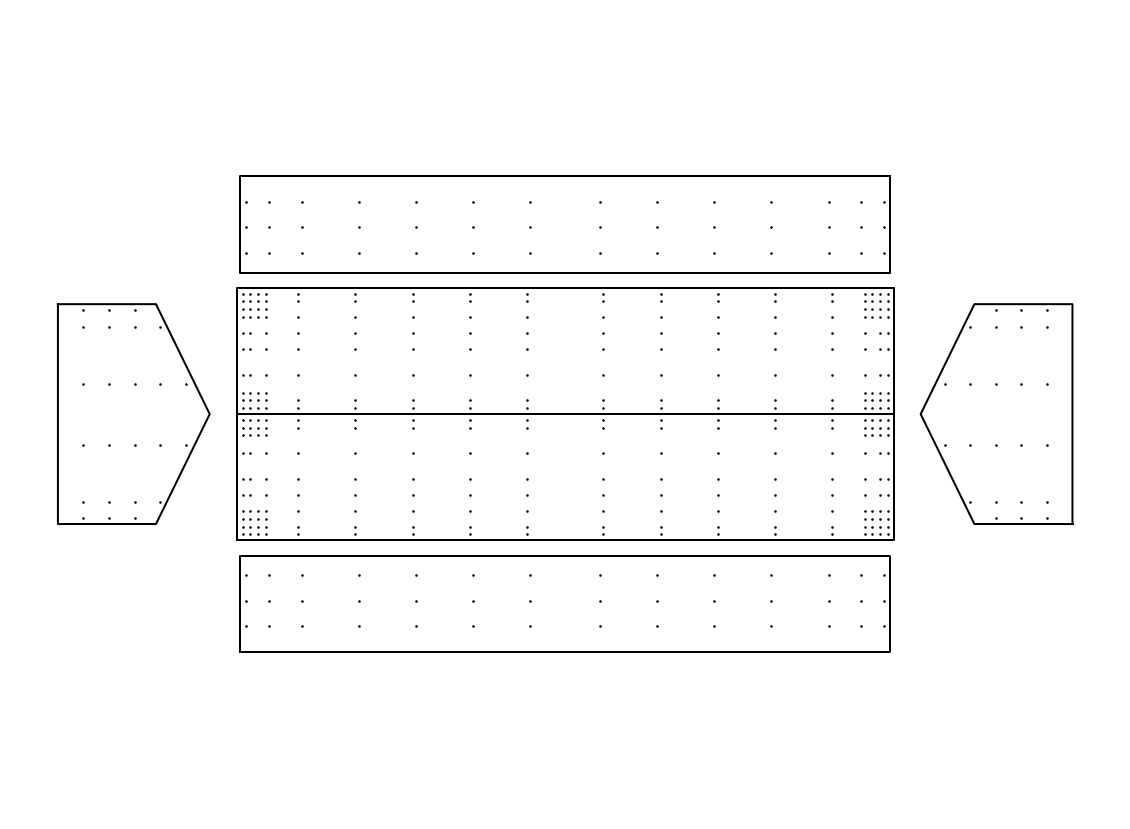

In [12]:
fig = plt.figure(figsize=[20,15])
ax = fig.add_subplot()

bldg_iso.plotEdges(ax=ax,showName=False)
bldg_iso.plotTaps(ax=ax,showTapNo=False)
# bldg_iso.plotZones(ax=ax)

# bldg_iso.plotTribs(ax=ax)
# bldg_iso.plotPanels(ax=ax,aIdx=2)

ax.axis('equal')
ax.axis('off')
if saveFigs:
    fig.savefig(figDir+"tapLayout.svg",format='svg',dpi=1200, bbox_inches='tight')



## Wind field

### Exposure conditions

Tunnel configurations for the considered exposures

### Read data

In [57]:
sFreq = 1600
dt = 1/sFreq

pDir =profileDir+"tngE2/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")
W_TH = np.load(pDir+"WofT.npy")
vel_OP = wind.profile(name="BLWT - OP", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=32,keepTH=True)

pDir =profileDir+"tngE3/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")
W_TH = np.load(pDir+"WofT.npy")
vel_SU = wind.profile(name="BLWT - SU", Z=Z,UofT=U_TH.transpose(),VofT=V_TH.transpose(),WofT=W_TH.transpose(),H=H,dt=dt,nSpectAvg=32,keepTH=True)

del(U_TH, V_TH, W_TH)

In [14]:
if exp == 'E2':
    z0 = 0.02
    vel_WT = vel_OP
elif exp == 'E3':
    z0 = 0.2
    vel_WT = vel_SU

es85 = wind.ESDU85(z0=0.02, Zref=H/lScl, Uref=25.0)
es74 = wind.ESDU74(z0=0.02, Zref=H/lScl, Uref=25.0)
vel_E2_ESDU = es85.toProfileObj()
vel_E2_ESDU.SpectH = es74.toProfileObj().SpectH
vel_E2_ESDU.name = r'ESDU ($z_0=0.02m$)'
vel_E2_ESDU.SpectH.name = r'ESDU ($z_0=0.02m$)'

es85 = wind.ESDU85(z0=0.2, Zref=H/lScl, Uref=25.0)
es74 = wind.ESDU74(z0=0.2, Zref=H/lScl, Uref=25.0)
vel_E3_ESDU = es85.toProfileObj()
vel_E3_ESDU.SpectH = es74.toProfileObj().SpectH
vel_E3_ESDU.name = r'ESDU ($z_0=0.2m$)'
vel_E3_ESDU.SpectH.name = r'ESDU ($z_0=0.2m$)'

vel = wind.Profiles([vel_OP, vel_E2_ESDU, vel_SU, vel_E3_ESDU])

In [15]:
print(figDir)

D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/__plots/


### Plot wind field

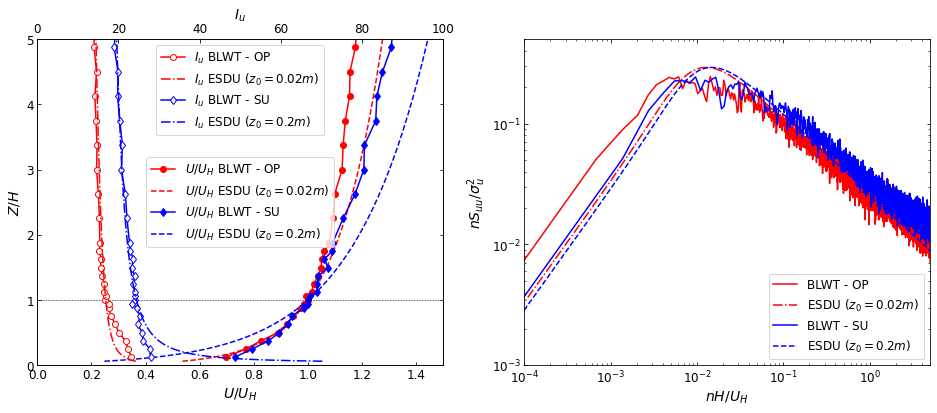

In [16]:
fig = vel.plot(fig=plt.figure(figsize=[16,6]),zLim=[0,5], IuLim=[0,100], Ulim=[0,1.5],
        col=['r','r','b','b','g','g'],
        marker_Iu=   ['o','None','d','None','v','None'],
        linestyle_Iu=['-','-.',  '-','-.',  '-','--'],
        marker_U=    ['o','None','d','None','v','None'],
        linestyle_U= ['-','--',  '-','--',  '-','--'],
        marker_Spect=   ['None','None','None','None','None','None'],
        linestyle_Spect=['-','-.',  '-','--',  '-','--'],
        alpha_Spect=[0.5, 1.0, 0.5, 1.0],
        IuLgndLoc='upper center', UlgndLoc='center',
        fontSz_axLbl=14, fontSz_axNum=12, fontSz_lgnd=12,
        freqLim=[1e-4, 5], rSuuLim=[1e-3,0.5]
        )
if saveFigs:
    fig.savefig(figDir+"windField.svg",format='svg',dpi=1200, bbox_inches='tight')

## Surface pressure, $C_p$

### Read data

In [17]:
analogChannels_idxs={
                'main_pitot': 0,
                'xref_pitot': 2,
            }
pressureExtraChannels_tapNos={
                'main_pitot_zero': 2909,
                'main_pitot_queue': 2910,
                '20inch_pitot_zero': 2907,
                '20inch_pitot_queue': 2908,
                'Uh_pitot_zero': 2905,
                'Uh_pitot_queue': 2906,
            }

peakSpecs = wind.DEFAULT_PEAK_SPECS
# peakSpecs = {
#                 'method':'minmax',
#             }
peakSpecs['Num_seg'] = 10
peakSpecs['Duration'] = 10
peakSpecs['prob_non_excd'] = 0.8

In [78]:

cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    # lowpassFreq=222.223,
    Ntaps=440,
)
winsound.Beep(1000, 1000)
print((cp_raw.CpTH.shape))

(40, 440, 40000)


In [69]:
cp = wind.bldgCp(
                bldgName=f"nrcNB{caseID}{caseID}",
                faces=faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                caseName=caseToRun,
                refProfile=vel_WT,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH,
                badTaps=None,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
winsound.Beep(1000, 1000)

In [89]:
print(np.mean(cp.Uref))
print(cp.lScl)

12.148864314055455
0.01


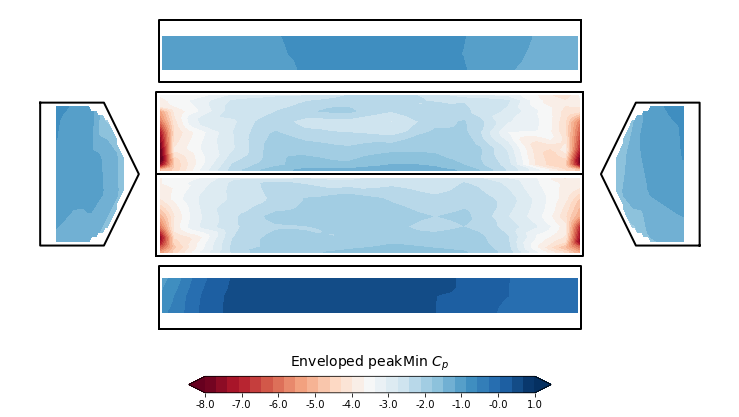

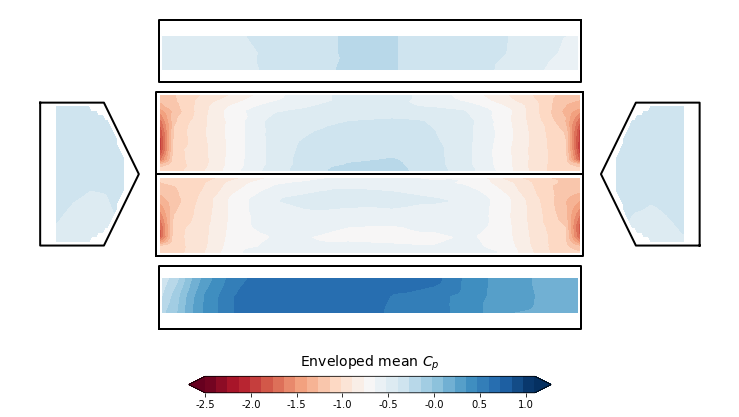

In [21]:
from matplotlib.ticker import FuncFormatter

# fld, fldrange, ticks = 'mean', [-2.5, 1.1], np.linspace(-2.5,1.0,8)
fld, fldrange, ticks = 'peakMin', [-8., 1.], np.linspace(-8,1.0,10)

fig = plt.figure(figsize=[13,8])
ax = plt.subplot()
im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$")
cp.plotEdges(ax=ax, showName=False)
ax.axis('equal')
ax.axis('off')
# cbar = fig.colorbar(im[0], ax=ax, orientation='vertical',aspect=20,shrink=0.5,pad=0.0)
# cbar.set_label(fld+r" $C_p$", fontsize=14, rotation=270, labelpad=20)
# cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))
cbar = fig.colorbar(im[0], ax=ax, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
cbar.set_ticks(ticks)
cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=14, rotation=0, labelpad=10)
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.xaxis.set_label_position('top')
# cbar.ax.tick_params(labeltop=True, top=True)
# cbar.ax.set_ylabel('Label', rotation=270, labelpad=15)
# cbar.ax.set_title('Title', rotation=270, pad=20)
if saveFigs:
    fig.savefig(figDir+f"nrcNB{caseID}{exp}_Cp_{fld}.svg",format='svg',dpi=1200, bbox_inches='tight')



fld, fldrange, ticks = 'mean', [-2.5, 1.1], np.linspace(-2.5,1.0,8)

fig = plt.figure(figsize=[13,8])
ax = plt.subplot()
im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$")
cp.plotEdges(ax=ax, showName=False)
ax.axis('equal')
ax.axis('off')
cbar = fig.colorbar(im[0], ax=ax, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
cbar.set_ticks(ticks)
cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=14, rotation=0, labelpad=10)
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.xaxis.set_label_position('top')
if saveFigs:
    fig.savefig(figDir+f"nrcNB{caseID}{exp}_Cp_{fld}.svg",format='svg',dpi=1200, bbox_inches='tight')

#### Wind tunnel data

### $C_p$ Plots

#### Local pressure

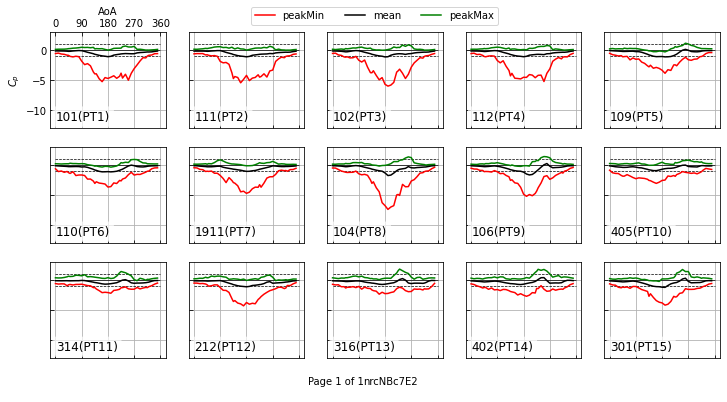

In [30]:
# figs = cp.plotTapCpStatsPerAoA(xticks=np.linspace(0,360,5),pageNo_xy=(0.5,0.06),nCols=7, figsize=[20,20],mrkrs=['None','None','None'], fldRange=[-13,3])#,fields=['mean','std'])

tapsToPlot=[101, 111, 102, 112, 109, 110, 1911, 104, 106, 405, 314, 212, 316, 402, 301]
figs = cp.plotTapCpStatsPerAoA(tapsToPlot=tapsToPlot,
                xticks=np.linspace(0,360,5),pageNo_xy=(0.5,0.04),nCols=5, nRows=3, figsize=[12,6],mrkrs=['None','None','None'], fldRange=[-13,3],
                legend_bbox_to_anchor=(0.5, 0.95))#,fields=['mean','std'])

# if saveFigs:
#     for p,fig in enumerate(figs):
#         fig.savefig(figDir+f"nrcNB{caseID}{exp}_CpStatsPerAoA_pg_{p+1}.svg",format='svg',dpi=1200, bbox_inches='tight')


In [23]:
# nrow, ncol = 8, 5

# fld = 'mean'
# fldRange=[-1.6,0.8]

# fig, axs = plt.subplots(nrow, ncol)
# fig.set_figheight(4*nrow)
# fig.set_figwidth(6*ncol)
# fig.subplots_adjust(wspace=0.0, hspace=0.0)

# for d,D in enumerate(cp.AoA):
#     ax = axs[d//ncol, d%ncol]
#     cp.plotTapCpStatContour(fieldName=fld,dxnIdx=d,ax=ax,fldRange=fldRange)
#     cp.plotEdges(ax=ax,showName=False)
#     # nrcNBc2E2.plotTaps(ax=ax,dotSz=1)
#     ax.axis('off')
#     ax.axis('equal')
#     # ax.set_title(r'$\theta='+str(np.round(D,0))+r'^\circ$',fontsize=16)

# if saveFigs:
#     fig.savefig(figDir+"Cp_"+fld+".svg",format='svg',dpi=600, bbox_inches='tight')
print(np.mean(cp.Uref))
print(vel_OP.IuH)
print(vel_SU.IuH)


12.091346411813303
0.1664879607937308
0.2409258690938113


In [24]:

# file = r"D:/temp/th.csv"
# x = cp_raw.CpTH[0,0,:]
# print(np.shape(x))
# M = pd.DataFrame(x)
# M.to_csv(file,sep=',',header=None, index=None)

# peakMin, peakMax, details = wind.peak(x=x, method='gumbel_BLUE',gumbel_N=10,debugMode=False,detailedOutput=True)

# print(peakMax)
# print(peakMin)
# print(details)
# def func():
#     lst, lst2 = [7,], [7,]
#     lst3 = lst * 2
#     return lst3 == lst2.extend([lst])
# print(func())
x = asfj

NameError: name 'asfj' is not defined

#### Area averaged load

In [ ]:
NBCC_A_min = [
            [0.1, 1, 10, 100], # c
            [0.1, 2.2, 10, 100], # s
            [0.1, 1, 10, 100], # r
            ]
NBCC_CpCg_min = np.array([
            [-5, -5, -4, -4],
            [-3.6, -3.6, -2.6, -2.6],
            [-2.45, -2.45, -2, -2]
            ],dtype=float)
NBCC_A_max = [0.1, 1, 10, 100]
NBCC_CpCg_max = np.array([0.75, 0.75, 0.5, 0.5],dtype=float)

ft2m_sq = 0.3048**2

ASCE_A_min = np.array([
            [0.1, 10, 500, 2000], # 3
            [0.1, 10, 500, 2000], # 2
            [0.1, 10, 500, 2000], # 1
            [0.1, 100, 500, 2000], # 1'
            ],dtype=float)*ft2m_sq
ASCE_GCp_min = np.array([
            [-3.2, -3.2, -1.4, -1.4], # 3
            [-2.3, -2.3, -1.4, -1.4], # 2
            [-1.7, -1.7, -1.0, -1.0], # 1
            [-0.9, -0.9, -0.4, -0.4], # 1'
            ],dtype=float)
ASCE_A_max = np.array([0.1, 100, 500, 2000],dtype=float)*ft2m_sq
ASCE_GCp_max = np.array([0.3, 0.3, 0.2, 0.2],dtype=float)


In [ ]:
from typing import List,Literal,Dict,Tuple,Any

def CpStatsAreaAvgCollected(self, mixNominalAreas=False, 
                    envelope:Literal['max','min','none']='none', 
                    extremesPerNominalArea:Literal['max','min','none']='none'):
    # [Nfaces][Nzones][Narea][Nflds][N_AoA,Npanels]
    zNames = []
    for z, zn in enumerate(self.zoneDict):
        zNames.append(self.zoneDict[zn][0]+'_'+self.zoneDict[zn][1])
    CpAavg = self.zoneDict
    for zm, zone_m in enumerate(CpAavg):
        if mixNominalAreas:
            CpAavg[zone_m][2] = {}
            for _, fld in enumerate(self.CpStatsAreaAvg[0][zm][0]):
                CpAavg[zone_m][2][fld] = None                
        else:
            CpAavg[zone_m][2] = []
            for a, _ in enumerate(self.faces[0].nominalPanelAreas):
                CpAavg[zone_m][2].append({})
                for _, fld in enumerate(self.CpStatsAreaAvg[0][zm][0]):
                    CpAavg[zone_m][2][a][fld] = None

    def envelopeFld(fld): # assumes all fields have the AoA as the first index
        if envelope == 'max':
            return np.max(fld,axis=0,keepdims=True) 
        elif envelope == 'min':
            return np.min(fld,axis=0,keepdims=True)
        elif envelope == 'none':
            return fld

    def extremePerArea(fld):
        if extremesPerNominalArea == 'max':
            return np.max(fld,axis=1,keepdims=True) 
        elif extremesPerNominalArea == 'min':
            return np.min(fld,axis=1,keepdims=True)
        elif extremesPerNominalArea == 'none':
            return fld

    for f,fc in enumerate(self.faces):
        for z,zone in enumerate(fc.zoneDict):
            zIdx = zNames.index(fc.zoneDict[zone][0]+'_'+fc.zoneDict[zone][1])
            for a,_ in enumerate(fc.nominalPanelAreas):
                for _, fld in enumerate(self.CpStatsAreaAvg[f][z][a]):
                    if mixNominalAreas:
                        if CpAavg[zIdx][2][fld] is None:
                            CpAavg[zIdx][2][fld] = {}
                            CpAavg[zIdx][2][fld] = envelopeFld(self.CpStatsAreaAvg[f][z][a][fld])
                        else:
                            CpAavg[zIdx][2][fld] = np.concatenate((CpAavg[zIdx][2][fld], envelopeFld(self.CpStatsAreaAvg[f][z][a][fld])), axis=1)
                    else:
                        if CpAavg[zIdx][2][a][fld] is None:
                            CpAavg[zIdx][2][a][fld] = {}
                            CpAavg[zIdx][2][a][fld] = envelopeFld(self.CpStatsAreaAvg[f][z][a][fld])
                        else:
                            CpAavg[zIdx][2][a][fld] = np.concatenate((CpAavg[zIdx][2][a][fld], envelopeFld(self.CpStatsAreaAvg[f][z][a][fld]) ), axis=1)
    if not extremesPerNominalArea == 'none' and not mixNominalAreas:
        __CpAavg = CpAavg
        CpAavg = self.zoneDict
        for zm, zone_m in enumerate(CpAavg):
            CpAavg[zone_m][2] = {}
            for _, fld in enumerate(self.CpStatsAreaAvg[0][zm][0]):
                CpAavg[zone_m][2][fld] = np.zeros_like(self.faces[0].nominalPanelAreas)
                for a, _ in enumerate(self.faces[0].nominalPanelAreas):
                    CpAavg[zone_m][2][fld][a] = np.squeeze(extremePerArea(__CpAavg[zone_m][2][a][fld]))
    return CpAavg

In [ ]:
print(np.shape(cp.CpStatsAreaAvgCollected(mixNominalAreas=True,envelope='min',extremesPerNominalArea='min')[0][2]['peakMin']))
print(np.shape(cp.panelAreas[0][2]))

In [ ]:
A = np.array(bldg[0].nominalPanelAreas)
A = np.multiply(A, np.power(1/bldg.lScl,2))
durstFactor = 1.53**2
ASCE_directionalityFactor = 0.85
fact_NBCC_2_ASCE = (1/ASCE_directionalityFactor)*(1/durstFactor)

nrow, ncol = 1, 3
fig, axs = plt.subplots(nrow, ncol)
fig.set_figheight(4*nrow)
fig.set_figwidth(5*ncol)

titles = ['Corner', 'Edge', 'Field']
for z in range(ncol):
    ax = axs[z]
    cpAvg = CpStatsAreaAvgCollected(lesCp_E2, envelope='low',extremesPerNominalArea='low')
    ax.semilogx(A, cpAvg[z][2]['peakMin']*fact_NBCC_2_ASCE,'or',label='LES')
    cpAvg = CpStatsAreaAvgCollected(wtCp_tngE2,envelope='low',extremesPerNominalArea='low')
    ax.semilogx(A, cpAvg[z][2]['peakMin']*fact_NBCC_2_ASCE,'db',label='BLWT')
    ax.semilogx(NBCC_A_min[z], NBCC_CpCg_min[z]*fact_NBCC_2_ASCE,'-k',lw=2,label='NBCC-2020')
    ax.semilogx(ASCE_A_min[z], ASCE_GCp_min[z],'--k',lw=2,label='ASCE 7-22')
    if z == 2:
        ax.semilogx(ASCE_A_min[z+1], ASCE_GCp_min[z+1],'--k',lw=2)

    cpAvg = lesCp_E2.CpStatsAreaAvgCollected(envelope='high',extremesPerNominalArea='high')
    ax.semilogx(A, cpAvg[z][2]['peakMax']*fact_NBCC_2_ASCE,'or')
    cpAvg = wtCp_tngE2.CpStatsAreaAvgCollected(envelope='high',extremesPerNominalArea='high')
    ax.semilogx(A, cpAvg[z][2]['peakMax']*fact_NBCC_2_ASCE,'db')
    ax.semilogx(NBCC_A_max, NBCC_CpCg_max*fact_NBCC_2_ASCE,'-k',lw=2)
    ax.semilogx(ASCE_A_max, ASCE_GCp_max,'--k',lw=2,)


    ax.set_ylim([-6,1])
    ax.set_xlim([0.1,100])
    ax.tick_params(axis='both',direction='in',which='both',top=True,right=True)
    ax.invert_yaxis()
    ax.grid('both')
    ax.set_ylabel(r'$GC_p$')
    ax.set_xlabel(r'A [$m^2$]')
    ax.set_title(titles[z])
    if z == 2:
        ax.legend()

if saveFigs:
    fig.savefig(figDir+"areaAvgGCp_LESvsWTvsCode.svg",format='svg',dpi=1200, bbox_inches='tight')

In [ ]:
print(lesCp_E2.CpStatsAreaAvgCollected(envelope='low',extremesPerNominalArea='low'))